In [1]:
import os
import re
import pandas as pd
from time import time
import datetime
import numpy as np
import spacy
import nltk
import wrds
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from tqdm import tqdm
import json

In [2]:
RANDOM_SEED = 7
DATA_DIR = "../data"
INTERM_DIR = '../compiled_data'

wsb_data_path = os.path.join(DATA_DIR, 'wsb_comments_raw.csv')
stock_data_path = os.path.join(DATA_DIR, 'GME')

# db = wrds.Connection(wrds_username='debabech', wrds_passeword='Electro1004$')
# db.create_pgpass_file()
# permcos = db.get_table(library='crsp', table='stocknames')[
#     ["permco", "ticker"]]

# efficiency and accuracy --> "en_core_web_trf"
nlp = spacy.load("en_core_web_sm")

In [3]:
# Define functions to load our data

def load_wsb_data(data_path, nrows=None, cols=['author', 'body','created_utc', 'score', 'link_id', 'is_submitter','permalink']):
    "Load wsb data, nrows None indicates all rows, otherwise specified integer of rows"
    data = pd.read_csv(wsb_data_path, nrows = nrows, delimiter=',', usecols=cols)
    
    data = data[data['author'] != '[deleted]']
    data = data[data['body'] != '[deleted]']
    data = data[data['body'] != '[removed]']
    
    data['created_utc'] = pd.to_numeric(data['created_utc'], errors='coerce')
    data = data.dropna(subset=['created_utc'])
    data['created_utc'] = data['created_utc'].astype(int)

    data['created_utc'] = data['created_utc'].apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    data = data.loc[data['created_utc'] > '2000']
    return data

def load_stock_wrds(ticker):
    permco = permcos[permcos.ticker == ticker].permco.values[0]
    # to 2021-03-25 ??
    req = f"select prc, date from crsp.dsf where permco in ({permco}) and date >='2012-01-31' and date <='2021-02-16'"
    asset = db.raw_sql(req, date_cols=['date'])
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.prc).diff(1)

    return asset["log_ret"]


def load_stock_yh(ticker):
    asset = yf.download(ticker, interval='1d',
                        start="2012-01-31", end="2021-02-16")
    asset = asset.dropna()
    asset["log_ret"] = np.log(asset.Close - asset.Open) #np.log(asset.Open).diff(1).shift(-1)

    return asset["log_ret"]


In [4]:
# Load the WSB textual data
wsb_df = load_wsb_data(wsb_data_path, None)

# discussion_thread seemed to most precisely and consistently 
# bring up the daily/weekend/weekly discussion threads
wsb_df = wsb_df.loc[wsb_df.permalink.str.contains('discussion_thread')] 
wsb_df['thread_type'] = wsb_df.permalink.apply(lambda x: x.split('/')[-3])

wsb_df.to_csv(os.path.join(DATA_DIR, 'wsb_discussion_threads.csv'))

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (2,14,16,19,20,24,26) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [4]:
wsb_df = pd.read_csv(os.path.join(DATA_DIR, 'wsb_discussion_threads.csv'))

/home/kamran/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


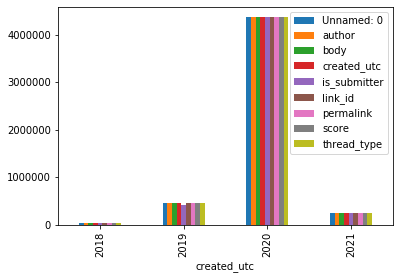

In [5]:
wsb_df.groupby(wsb_df["created_utc"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.year).count().plot(kind="bar")

In [6]:
class PreProcessing:

    def __init__(self, wsb_data, lemmatize=True, lower_case=True, rem_stopwords=True, rem_punctuation=True):
        """
        Initialise all class parameters

        :param data: nonempty pandas dataframe, wsb dataframe 
        :param lemmatize: bool, whether to perform lemmatization
        :param lower_case: bool, whether to lowercase
        :param rem_stopwords: bool, whether to remove stopwords
        :param tokenize: bool, whether to tokenize
        """

        self.wsb_data = wsb_data
        self.lemmatize = lemmatize
        self.lower_case = lower_case
        self.rem_stopwords = rem_stopwords
        self.rem_punctuation = rem_punctuation

    # Ensure Parameter types
    # K: need to add to this one gradually as we add columns that we use etc.
    @property
    def wsb_data(self):
        return self._wsb_data

    @wsb_data.setter
    def wsb_data(self, wsb_data):

        req_columns = ['author', 'body', 'created_utc']
        str_columns = ['body']
        date_columns = ['created_utc']

        # Ensure the provided object is a dataframe
        if not isinstance(wsb_data, pd.DataFrame):
            raise Exception("The provided data must be a pandas Dataframe")

        # Ensure wsb dataframe is non empty
        if wsb_data.shape[0] == 0:
            raise Exception("Provided Dataframe is empty")

        # Ensure all required columns are provided
        missing_columns = set(req_columns).difference(
            set(wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} are missing from the provided dataframe!")

        # Ensure all column names don't have unexpected periods
        if '.' in list(''.join(wsb_data.columns.tolist())):
            raise Exception("All Column names must not include periods :'.'")

        # Ensure all string columns are strings
        non_str_columns = set(str_columns).difference(
            set(wsb_data.select_dtypes(include='object')))
        if len(non_str_columns) > 0:
            raise Exception(
                f'The columns {non_str_columns} are expected as string (pandas object) columns.')

        self._wsb_data = wsb_data

    @property
    def lemmatize(self):
        return self._lemmatize

    @lemmatize.setter
    def lemmatize(self, lemmatize):
        if not isinstance(lemmatize, bool) and lemmatize is not None:
            raise Exception(
                'lemmatize must be provided as a boolean parameter (True/False) or None to the class')
        self._lemmatize = lemmatize

    @property
    def lower_case(self):
        return self._lower_case

    @lower_case.setter
    def lower_case(self, lower_case):
        if not isinstance(lower_case, bool):
            raise Exception(
                'lower_case must be provided as a boolean parameter (True/False) to the class')
        self._lower_case = lower_case

    @property
    def rem_stopwords(self):
        return self._rem_stopwords

    @rem_stopwords.setter
    def rem_stopwords(self, rem_stopwords):
        if not isinstance(rem_stopwords, bool):
            raise Exception(
                'rem_stopwords must be provided as a boolean parameter (True/False) to the class')
        self._rem_stopwords = rem_stopwords

    @property
    def rem_punctuation(self):
        return self._rem_punctuation

    @rem_punctuation.setter
    def rem_punctuation(self, rem_punctuation):
        if not isinstance(rem_punctuation, bool):
            raise Exception(
                'rem_punctuation must be provided as a boolean parameter (True/False) to the class')
        self._rem_punctuation = rem_punctuation

#     @property
#     def tokenize(self):
#         return self._tokenize

#     @tokenize.setter
#     def tokenize(self, tokenize):
#         if not isinstance(tokenize, bool):
#             raise Exception(
#                 'tokenize must be provided as a boolean parameter (True/False) to the class')
#         self._tokenize = tokenize

    def clean_textual_data(self, textual_columns):

        # Ensure the provided textual columns exist, and if single string column name convert it into a list
        if len(textual_columns) < 1:
            raise Exception(
                'The number of textual columns to clean must be greater than 0')
        if isinstance(textual_columns, str):
            textual_columns = [textual_columns]
        missing_columns = set(textual_columns).difference(
            set(self.wsb_data.columns.tolist()))
        if len(missing_columns) > 0:
            raise Exception(
                f"The columns {missing_columns} to clean are missing from the wsb dataframe!")
            
        def rem_null(self, col_name):
            self.wsb_data = self.wsb_data[self.wsb_data[col_name].notna()]
            return self.wsb_data

        def lower_case_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].str.lower()
            return self.wsb_data

        def lemmatize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            lemmatizer = nltk.stem.WordNetLemmatizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def stemming_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            stemmer = nltk.stem.porter.PorterStemmer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [stemmer.stem(w) for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def tokenize_fn(self, col_name):
            w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in w_tokenizer.tokenize(x)])
            return self.wsb_data

        def rem_punctuation_fn(self, col_name):
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if w.isalnum()])
            return self.wsb_data

        def rem_stopwords_fn(self, col_name):
            "stopwords dictionary considered English, wsb is an english forum"
            remove_elements = set(nltk.corpus.stopwords.words('english'))
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: [w for w in x if not w in remove_elements])
            return self.wsb_data

        def remove_tokenization(self, col_name):
            "Necessary as final step to untokenize in case desired, tokenization required for other functions to not break"
            self.wsb_data[col_name] = self.wsb_data[col_name].apply(
                lambda x: ' '.join(x))
            return self.wsb_data

        for textual_col in textual_columns:
            
            rem_null(self, textual_col)

            if self.lower_case:
                lower_case_fn(self, textual_col)

            # lemmatize tokens if true, if false, stem tokens, if None then just tokenize
            if self.lemmatize:
                lemmatize_fn(self, textual_col)
            elif self.lemmatize == False:
                stemming_fn(self, textual_col)
            else:
                tokenize_fn(self, textual_col)

            if self.rem_punctuation:
                rem_punctuation_fn(self, textual_col)
            if self.rem_stopwords:
                rem_stopwords_fn(self, textual_col)
                
            remove_tokenization(self, textual_col)

        return self.wsb_data

In [7]:
WSBPreProcessing = PreProcessing(
    wsb_df, lemmatize=None, lower_case=True, rem_stopwords=True, rem_punctuation=True)
WSBPreProcessing.clean_textual_data('body')
useful_columns = ['author', 'body', 'created_utc', 'score', 'link_id']
WSB_preprocessed_data = WSBPreProcessing.wsb_data[useful_columns]

/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [8]:
def rem_url_at(df):
    raw = []
    for sentence in tqdm(df['body']):
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'
                          '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sentence)
        sentence = re.sub("(@[A-Za-z0-9_]+)", "", sentence)
        raw.append(sentence)
    df['body'] = raw

    return df


def tagging(df):
    pos,tag,dep,shape = [],[],[],[]
    for sentence in tqdm(df['body']):
        pos_tmp,tag_tmp,dep_tmp,shape_tmp = [],[],[],[]
        for token in nlp(sentence):
            pos_tmp.append(token.pos_)
            tag_tmp.append(token.tag_)
            dep_tmp.append(token.dep_)
            shape_tmp.append(token.shape_)
        pos.append(pos_tmp)
        tag.append(tag_tmp)
        dep.append(dep_tmp)
        shape.append(shape_tmp)

    df['Pos'] = pos
    df['Tag'] = tag
    df['Dep'] = dep
    df['Shape'] = shape

    return df

In [9]:
WSB_preprocessed_data = rem_url_at(WSB_preprocessed_data)
#WSB_preprocessed_data = tagging(WSB_preprocessed_data)

WSB_preprocessed_data.replace('', np.nan, inplace=True)
WSB_preprocessed_data = WSB_preprocessed_data.dropna(how='any', axis=0)
WSB_preprocessed_data = WSB_preprocessed_data[WSB_preprocessed_data['body'].map(
    lambda d: len(d)) > 0]


100%|██████████| 5093147/5093147 [00:07<00:00, 711747.13it/s]
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kamran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:5244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


## Sentiment Analyser
- Flair
- Vader
- Blob

In [10]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')


2022-01-06 14:07:56,246 loading file /home/kamran/.flair/models/sentiment-en-mix-distillbert_4.pt


In [11]:
## Moved away from using multiple senttiment analysis models, too much computation time, Vader most adapted to social media
# def sentiment_analyser(df, v=True, f=False, b=False, r_vader=0.8, r_fler=0.1, r_blob=0.1):

#     df_fler, df_vader, df_blob = [], [], []
#     for sentence in tqdm(df['body'], position=0):
#         if v:
#             df_vader.append(vader(sentence))
#         if f:
#             df_fler.append(fler(sentence))
#         if b:
#             df_blob.append(blob(sentence))
#     if v: 
#         df['VADER'] = df_vader
#     if f: 
#         df['FLAIR'] = df_fler
#     if b:
#         df['BLOB'] = df_blob

#     if v and f and b:
#         df['compound'] = df['VADER']*r_vader + \
#             df['FLAIR']*r_fler + df['BLOB']*r_blob
#     elif v and f and not b:
#         df['compound'] = df['VADER']*(r_vader+r_blob) + df['FLAIR']*r_fler
#     elif v and b and not f:
#         df['compound'] = df['VADER']*(r_vader+r_fler) + df['BLOB']*r_blob
#     else:
#         df['compound'] = df['VADER']

#     return df


# def vader(sentence):
#     analyzer = SentimentIntensityAnalyzer()
#     sentiment = analyzer.polarity_scores(sentence)['compound']
#     return float(sentiment)


# def fler(sentence):
#     s = Sentence(sentence)
#     classifier.predict(s)
#     sentiment = str(s.labels[0])
#     num = float(re.findall(r'\d+\.\d+', sentiment)[0])
#     if sentiment.find('POSITIVE') == -1:
#         num = num * -1
#     return num


# def blob(sentence):
#     sentiment = TextBlob(sentence).sentiment.polarity
#     return sentiment


# #WSB_preprocessed_data = sentiment_analyser(WSB_preprocessed_data)

In [12]:
import tqdm.notebook as tq

def sentiment_analyser(df):

    df_vader = []
    for sentence in tqdm(df['body'], position=0):
        df_vader.append(vader(sentence))
    sa_df = pd.DataFrame(df_vader)
    sa_df.index = df.index
    df['neg_sa'] = sa_df['neg']
    df['pos_sa'] = sa_df['pos']
    df['neu_sa'] = sa_df['neu']
    df['compound_sa'] = sa_df['compound']

    return df

def vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(sentence)
    return sentiment

In [13]:
import multiprocessing

n_splits = 8
n_rows = len(WSB_preprocessed_data)
chunks = [[int(i * n_rows/n_splits), int((i+1) * n_rows/n_splits)]  for i in range(n_splits)]

# function to perform vader analysis on portion of the table
def vader_worker(row_range):
    return sentiment_analyser(WSB_preprocessed_data.iloc[row_range[0]:row_range[1]])

p = multiprocessing.Pool(processes=n_splits) 
WSB_preprocessed_data = p.map(vader_worker, chunks)
p.close() 
del p

WSB_preprocessed_data = pd.concat(WSB_preprocessed_data)
WSB_preprocessed_data.to_pickle(INTERM_DIR+'/DiscussionThreadsSA/wsb_pkl')

 99%|█████████▊| 598229/605888 [2:02:07<01:31, 83.30it/s]/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/kamran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 

# Aggregate by day

In [355]:
def load_yfinance_data(ticker):
    
    tmp_ = yf.Ticker(ticker)

    # get historical market data
    hist = tmp_.history(period="10Y")
    hist = hist.drop(['Stock Splits', 'Dividends','Close','High','Low','Volume'], axis=1)
    hist.columns = [ticker + '_' + x for x in hist.columns]
    return hist

SPY = load_yfinance_data('SPY')
#DJI = load_yfinance_data('DJI')
#NDAQ = load_yfinance_data('NDAQ')
#INX = load_yfinance_data('INX')
#NDXE = load_yfinance_data('^NDXE')

df_tickers = pd.concat([SPY], axis=1)
df_tickers = df_tickers.reset_index()
df_tickers['Date'] = pd.to_datetime(df_tickers['Date'], unit='s')

In [356]:
df_tickers.head()

,Date,SPY_Open
0,2012-01-09,105.689713
1,2012-01-10,106.837442
2,2012-01-11,106.292492
3,2012-01-12,106.986068
4,2012-01-13,106.218148


In [357]:
df_tickers = df_tickers.set_index('Date')

# Calculate returns
returns = df_tickers.pct_change() # simple linear returns
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis=0, how='all')
returns = returns.fillna(returns.mean())

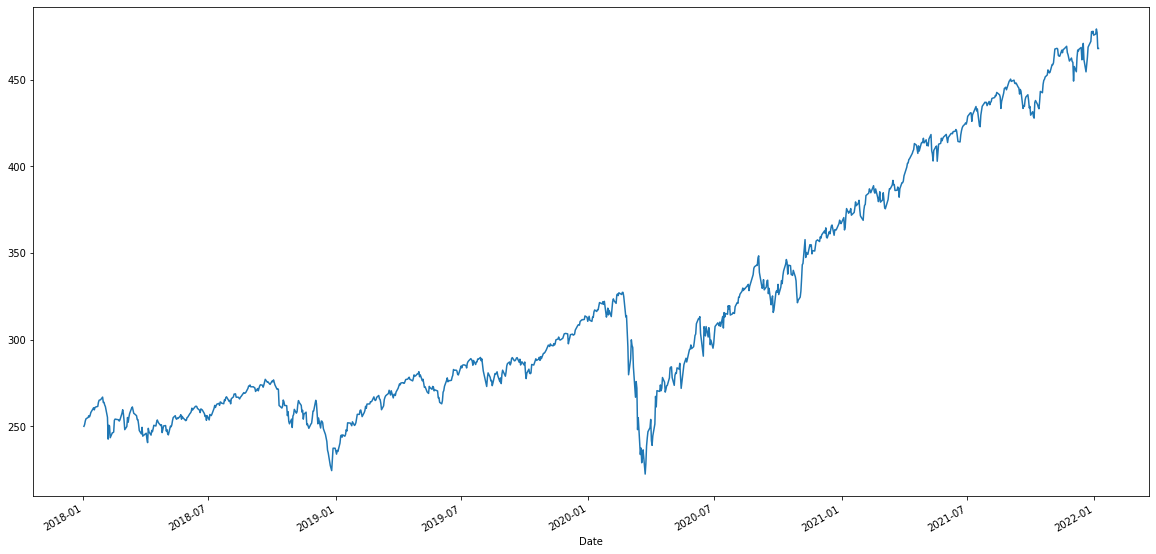

In [358]:
df_tickers.loc[df_tickers.index > '2018-01-01']['SPY_Open'].plot(figsize=(20,10))

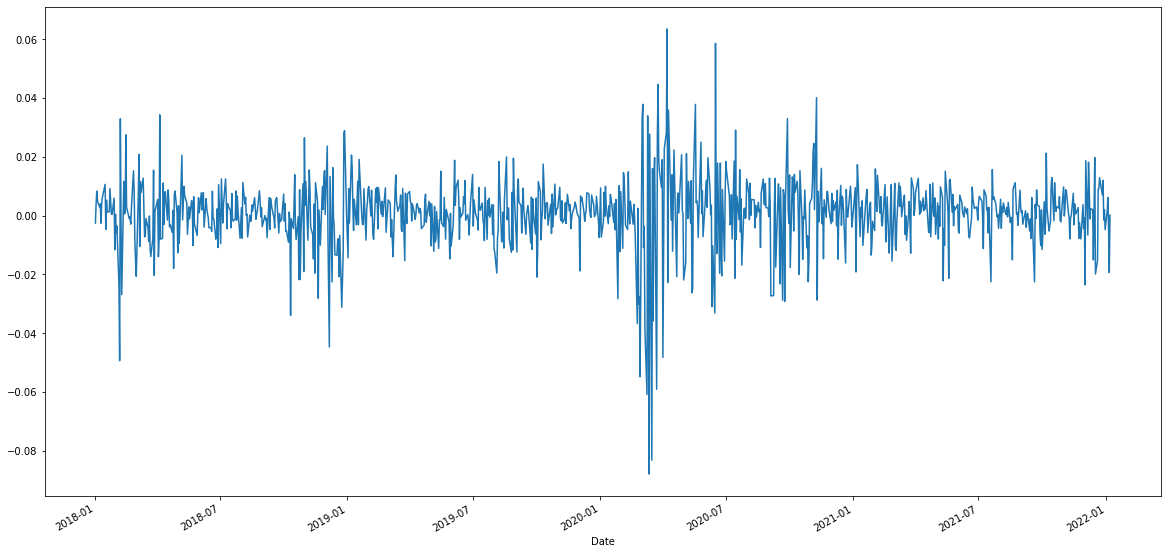

In [359]:
returns.loc[returns.index > '2018-01-01']['SPY_Open'].plot(figsize=(20,10))

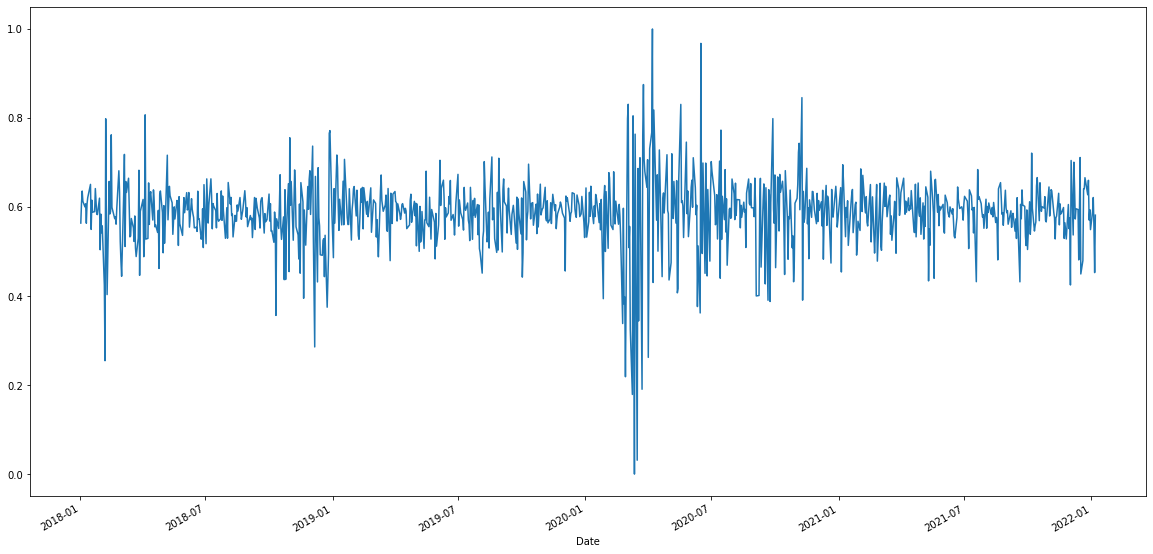

In [360]:
# minmax scale it
returns['SPY_Open'] = (returns['SPY_Open']-returns['SPY_Open'].min()) / (returns['SPY_Open'].max()-returns['SPY_Open'].min())
returns.loc[returns.index > '2018-01-01']['SPY_Open'].plot(figsize=(20,10))

In [361]:
WSB_preprocessed_data = pd.read_pickle(INTERM_DIR+'/DiscussionThreadsSA/wsb_pkl')
WSB_preprocessed_data['date'] = WSB_preprocessed_data["created_utc"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.date
WSB_preprocessed_data['date'] = pd.to_datetime(WSB_preprocessed_data['date'])

In [362]:
bull_lexicon = ['buy','call','forward','long','up','grow','rise','green','hold','carry','bull']
bear_lexicon = ['short','sell','down','drop','decrease','red','bear']

WSB_preprocessed_data['bull_count'] = WSB_preprocessed_data['body'].apply(lambda x: any(substring in x for substring in bull_lexicon))
WSB_preprocessed_data['bear_count'] = WSB_preprocessed_data['body'].apply(lambda x: any(substring in x for substring in bear_lexicon))

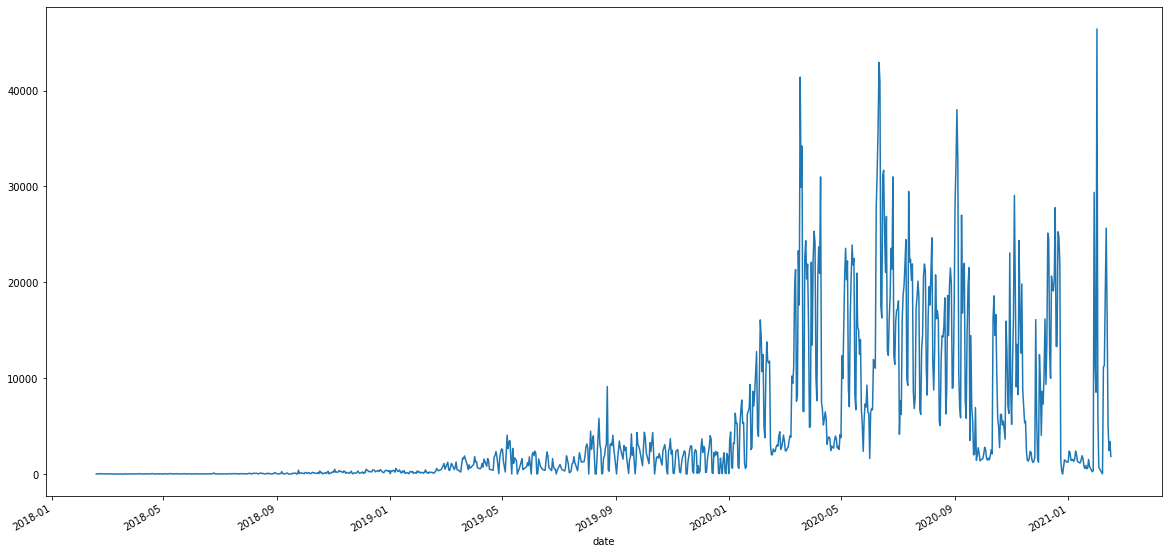

In [363]:
counts_per_day = WSB_preprocessed_data.reset_index().groupby('date')['index'].count()
counts_per_day.plot(figsize=(20,10))

In [364]:
#WSB_preprocessed_data = pd.merge(WSB_preprocessed_data, counts_per_day, left_on='date', right_index=True)
#WSB_preprocessed_data.head()

In [365]:
WSB_preprocessed_data['score'] = WSB_preprocessed_data['score'].astype(int)
WSB_preprocessed_data['score'] = WSB_preprocessed_data[['score']].apply(lambda x: x.fillna(x.mean()))
WSB_preprocessed_data['abs_score'] = np.abs(WSB_preprocessed_data['score'])

WSB_preprocessed_data = pd.merge(WSB_preprocessed_data.drop('abs_score', axis=1), 
                                 WSB_preprocessed_data.groupby('date')['abs_score'].sum(), left_on='date', right_index=True)

exp_scalar = 1.1
# Normalize score by total (absolute) score for that day
WSB_preprocessed_data['score_w'] = WSB_preprocessed_data['score']**exp_scalar /WSB_preprocessed_data['abs_score']
WSB_preprocessed_data = WSB_preprocessed_data.drop(['abs_score'], axis=1)

WSB_preprocessed_data['compound_sa'] = WSB_preprocessed_data['compound_sa'] * WSB_preprocessed_data['score_w']
WSB_preprocessed_data['neg_sa'] = WSB_preprocessed_data['neg_sa'] * WSB_preprocessed_data['score_w']
WSB_preprocessed_data['pos_sa'] = WSB_preprocessed_data['pos_sa'] * WSB_preprocessed_data['score_w']
WSB_preprocessed_data['neu_sa'] = WSB_preprocessed_data['neu_sa'] * WSB_preprocessed_data['score_w']
WSB_preprocessed_data['bull_count'] = WSB_preprocessed_data['bull_count'] * WSB_preprocessed_data['score_w']
WSB_preprocessed_data['bear_count'] = WSB_preprocessed_data['bear_count'] * WSB_preprocessed_data['score_w']

#WSB_preprocessed_data['compound'] = WSB_preprocessed_data['compound'] * np.log(1 + np.abs(WSB_preprocessed_data['score']))
#WSB_preprocessed_data['score'] = (WSB_preprocessed_data['score']+1-WSB_preprocessed_data['score'].mean()) / WSB_preprocessed_data['score'].std()

In [366]:
WSB_preprocessed_data = WSB_preprocessed_data.groupby('date')[['score','compound_sa','neg_sa','pos_sa','neu_sa','bear_count','bull_count']].agg(
    {'compound_sa' : ['sum'], 
     'neg_sa' : ['sum'], 
     'neu_sa' : ['sum'], 
     'pos_sa' : ['sum'],
     'bear_count' : ['sum'],
     'bull_count' : ['sum'],
     'score' : ['mean']}).reset_index()

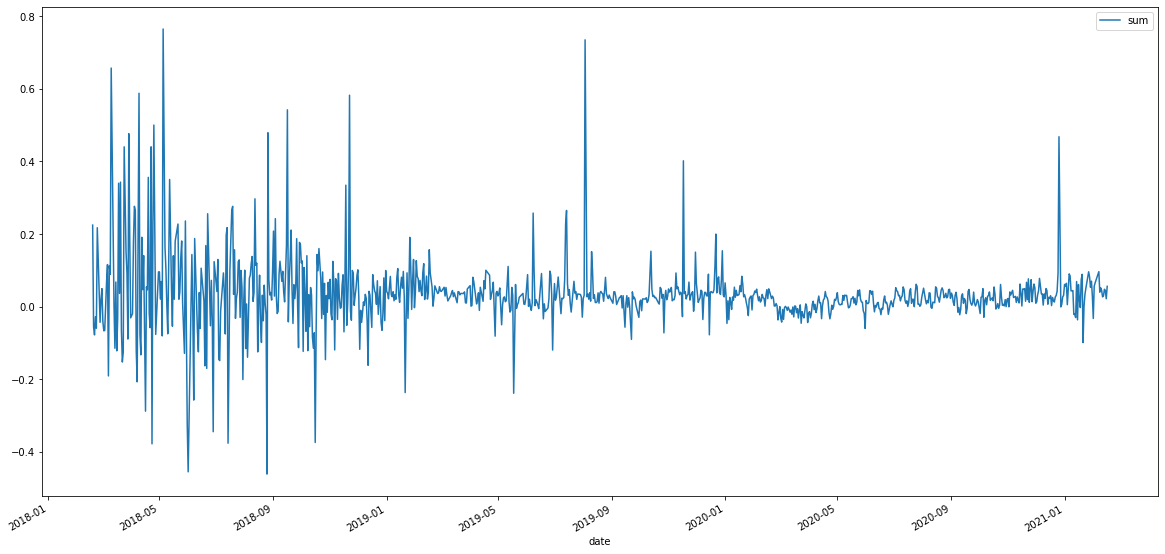

In [367]:
WSB_preprocessed_data.plot(x = 'date', y = 'compound_sa', figsize=(20,10))
plt.show()

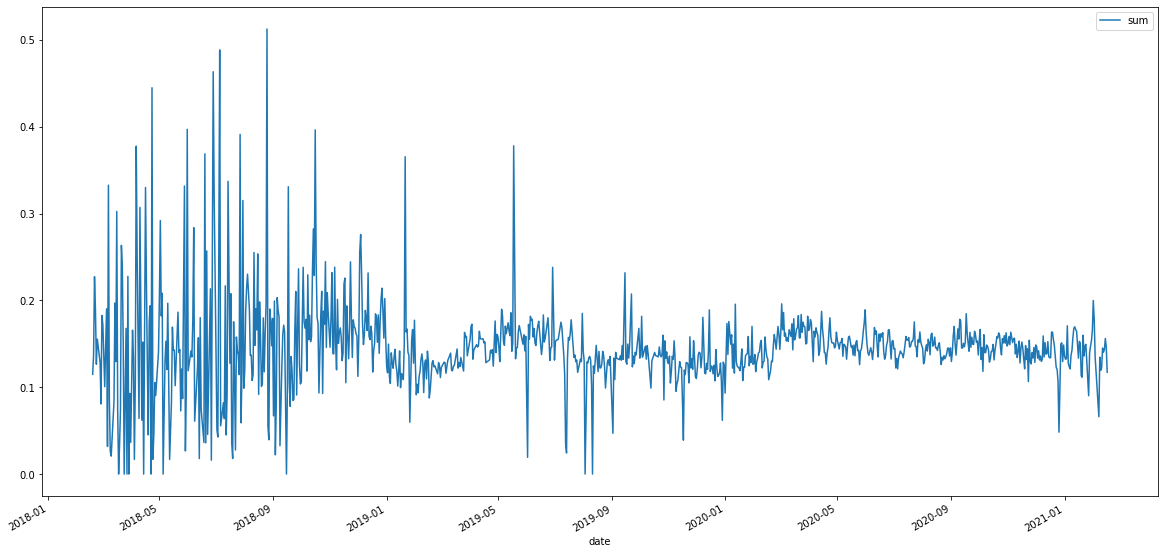

In [368]:
WSB_preprocessed_data.plot(x = 'date', y = 'neg_sa', figsize=(20,10))
plt.show()

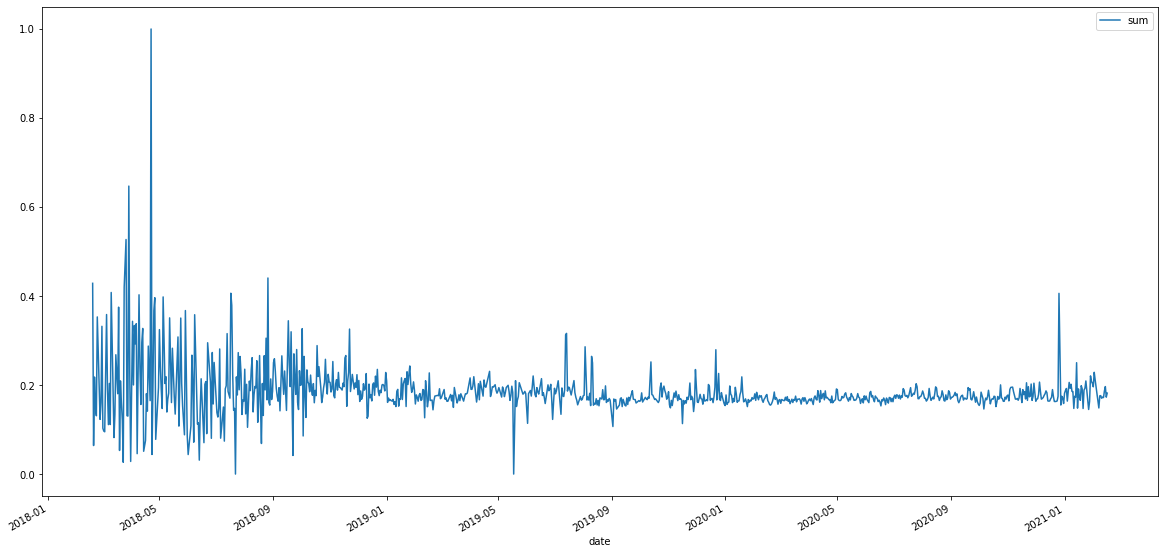

In [369]:
WSB_preprocessed_data.plot(x = 'date', y = 'pos_sa', figsize=(20,10))
plt.show()

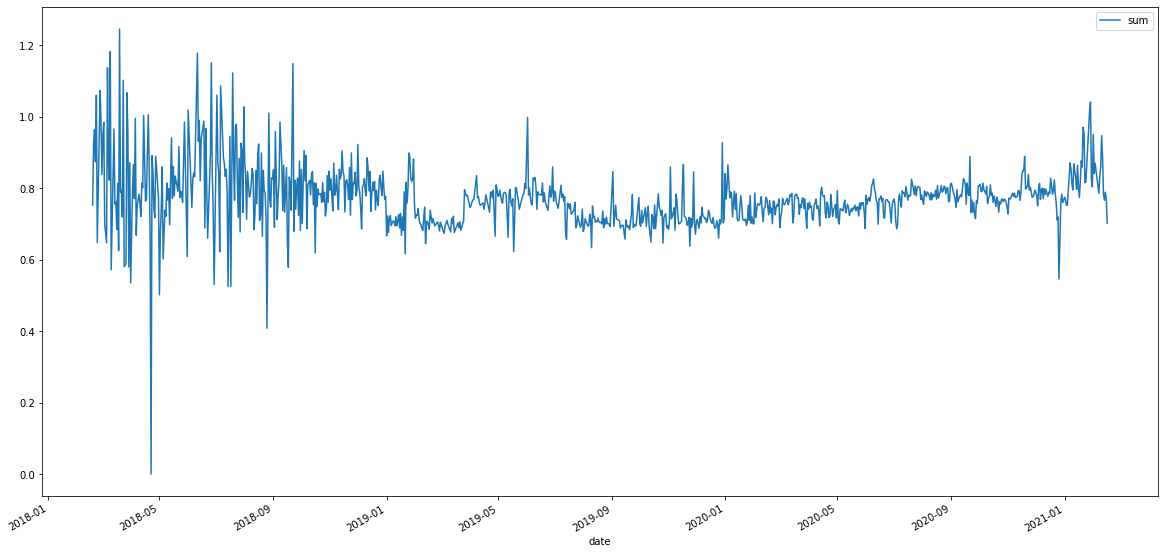

In [370]:
WSB_preprocessed_data.plot(x = 'date', y = 'neu_sa', figsize=(20,10))
plt.show()

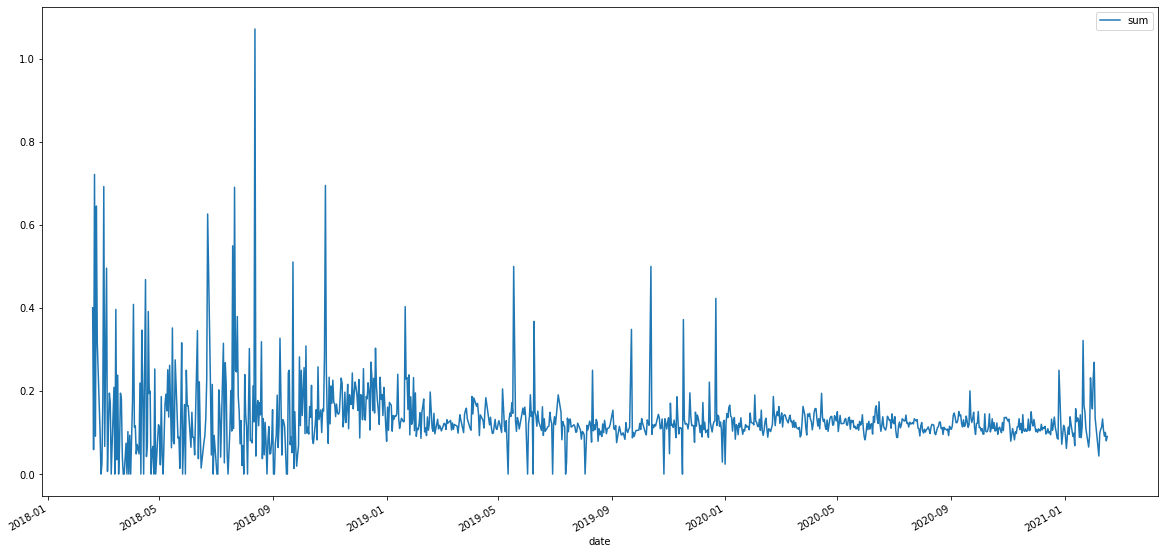

In [371]:
WSB_preprocessed_data.plot(x = 'date', y = 'bear_count', figsize=(20,10))
plt.show()

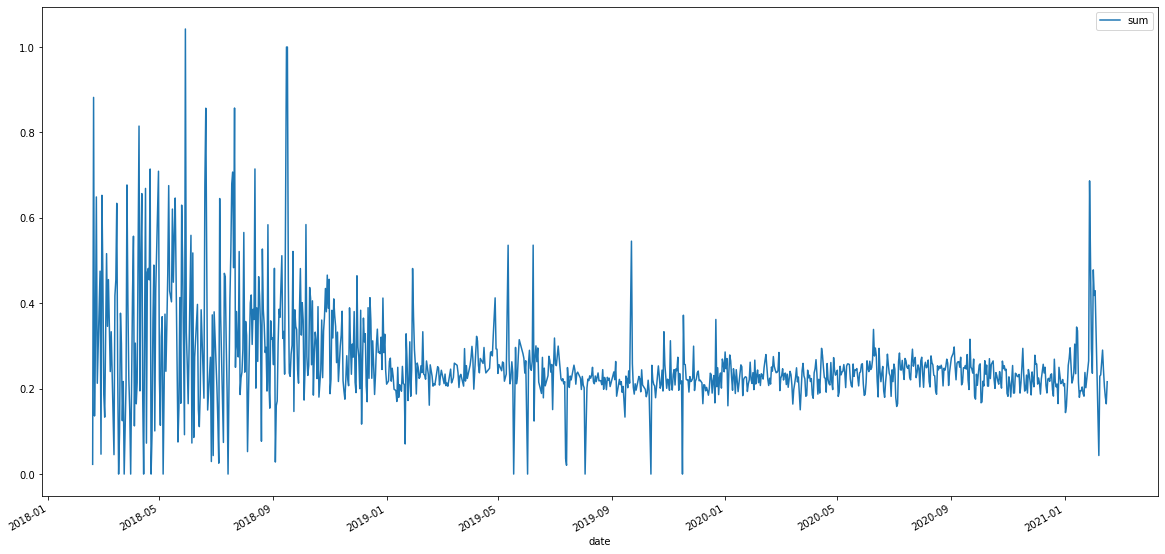

In [372]:
WSB_preprocessed_data.plot(x = 'date', y = 'bull_count', figsize=(20,10))
plt.show()

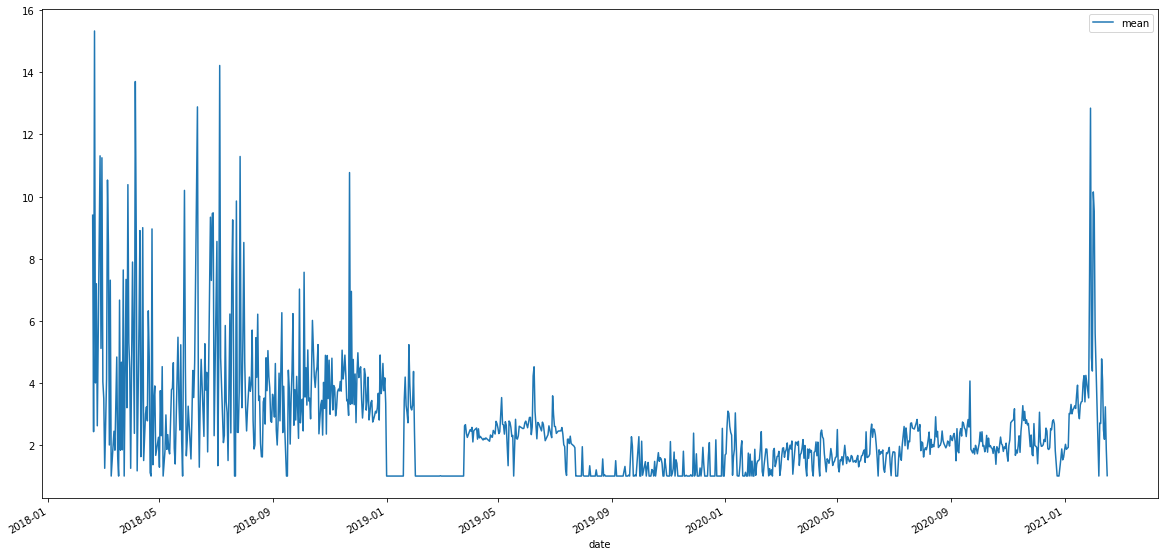

/home/kamran/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [373]:
WSB_preprocessed_data.plot(x = 'date', y = 'score', figsize=(20,10))
plt.show()
WSB_preprocessed_data = WSB_preprocessed_data.drop('score', axis=1)

In [374]:
WSB_preprocessed_data.columns = WSB_preprocessed_data.columns.map('_'.join)

### Fast Fourier Transform on Sentiment Analyses

In [375]:
from scipy.fftpack import fft, ifft

def fourier(df, n_dimensions, col):
    for n in n_dimensions:
        n = round(n)
        tmp_ = fft(df[col].values)
        tmp_[n:-n] = 0
        df[str(n)+'fourier'+col] = np.abs(ifft(tmp_))
    return df

# how to choose the values of fourier?
l = len(WSB_preprocessed_data)
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [100, 200], 'compound_sa_sum')
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [100, 200], 'pos_sa_sum')
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [100, 200], 'neg_sa_sum')
WSB_preprocessed_data = fourier(WSB_preprocessed_data, [100, 200], 'neu_sa_sum')
returns = fourier(returns, [200, 400], 'SPY_Open')

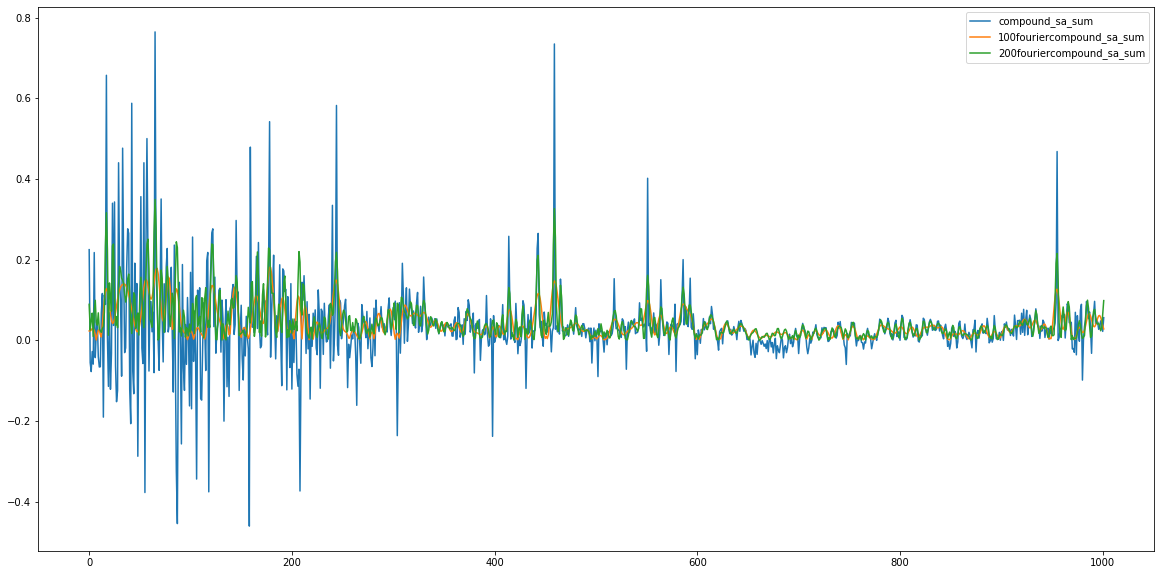

In [376]:
WSB_preprocessed_data[['compound_sa_sum','100fouriercompound_sa_sum','200fouriercompound_sa_sum']].plot(figsize=(20,10))

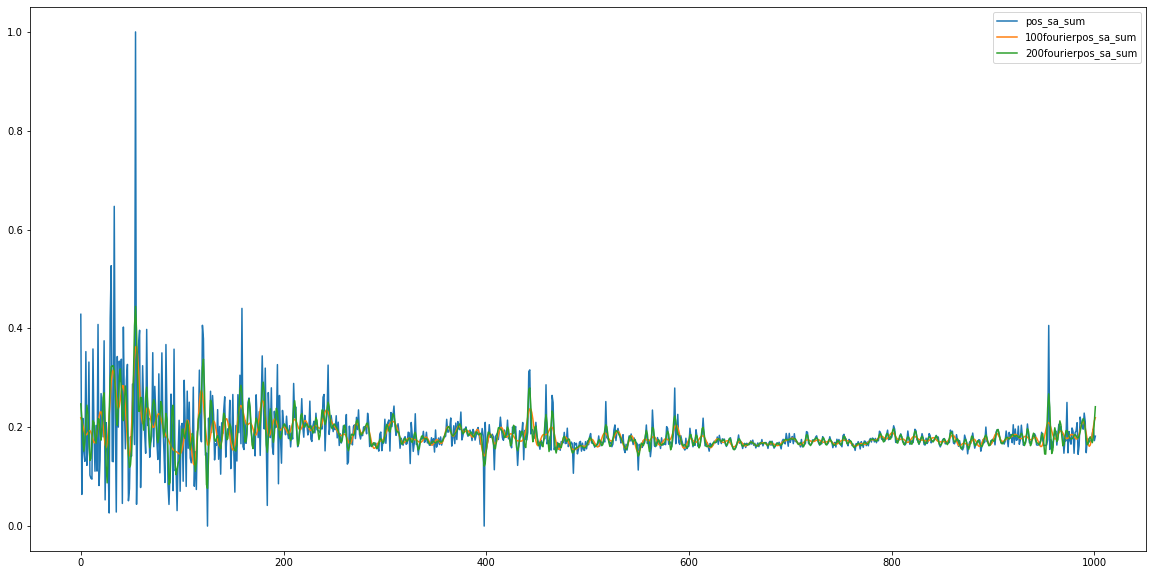

In [377]:
WSB_preprocessed_data[['pos_sa_sum','100fourierpos_sa_sum','200fourierpos_sa_sum']].plot(figsize=(20,10))

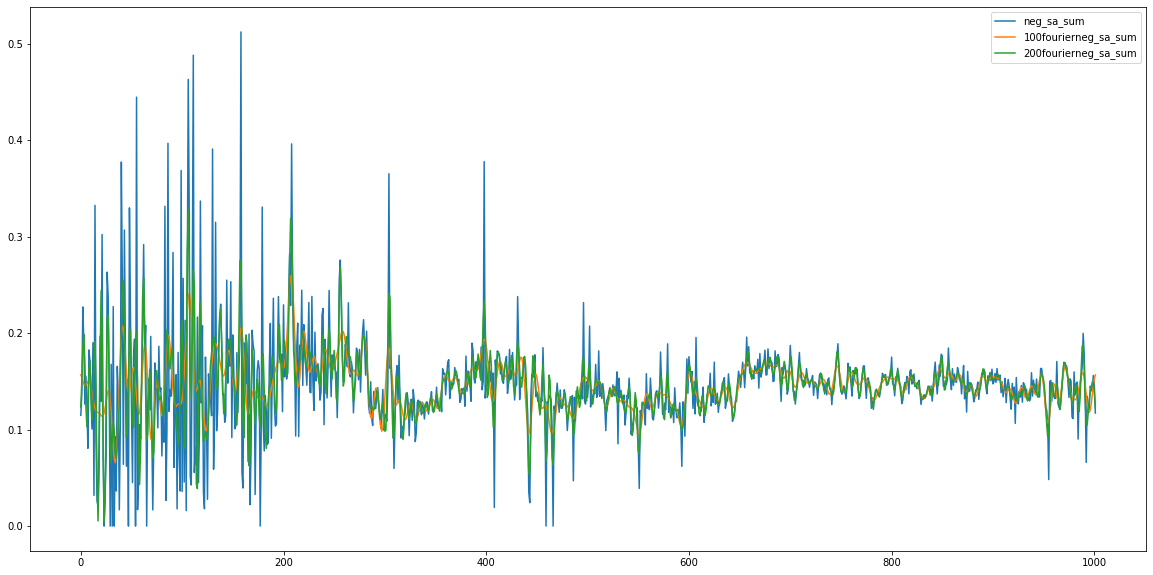

In [378]:
WSB_preprocessed_data[['neg_sa_sum','100fourierneg_sa_sum','200fourierneg_sa_sum']].plot(figsize=(20,10))

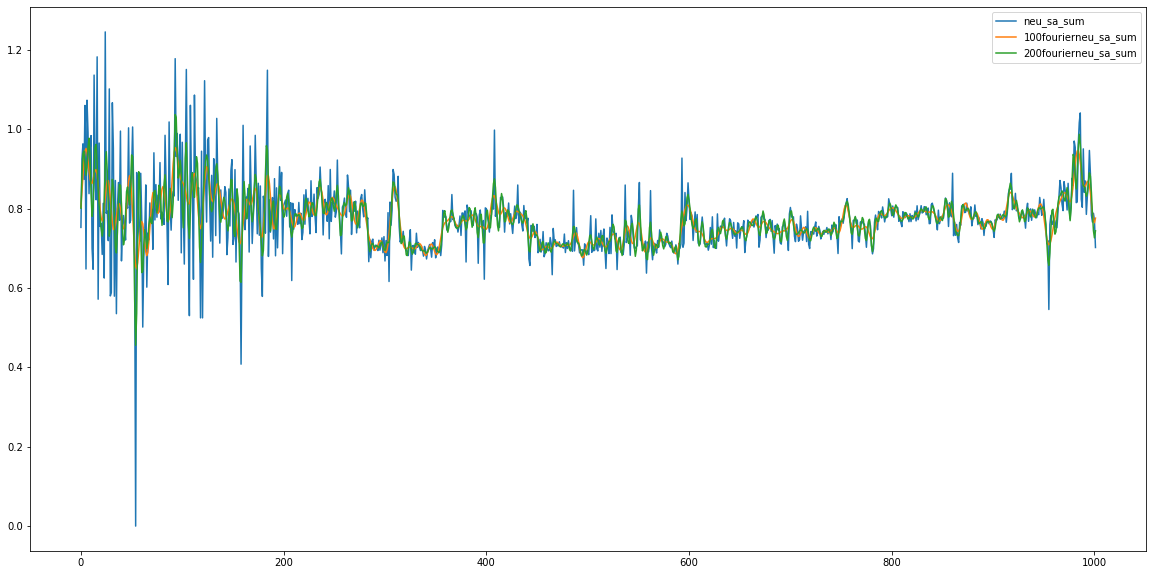

In [379]:
WSB_preprocessed_data[['neu_sa_sum','100fourierneu_sa_sum','200fourierneu_sa_sum']].plot(figsize=(20,10))

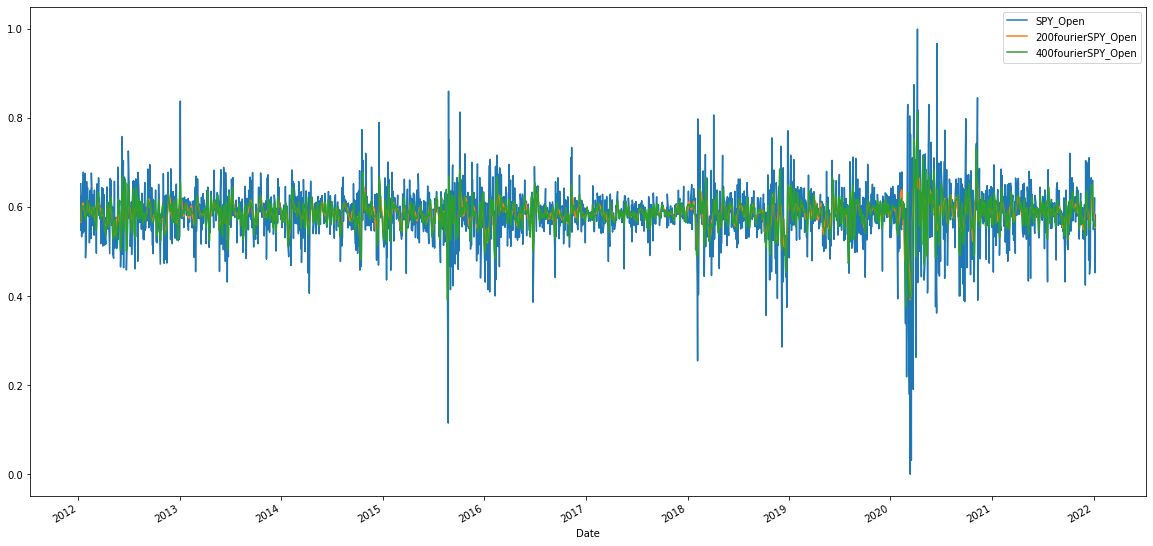

In [381]:
returns[['SPY_Open','200fourierSPY_Open','400fourierSPY_Open']].plot(figsize=(20,10))

In [382]:
WSB_preprocessed_data = WSB_preprocessed_data.drop(['compound_sa_sum','pos_sa_sum','neg_sa_sum','neu_sa_sum'], axis=1)

In [383]:
def merged_df(df, df_tickers):
    final_df = pd.merge(df, df_tickers, left_on='date_', right_on='Date')
    final_df = final_df.set_index('date_')
    return final_df

final_df = merged_df(WSB_preprocessed_data, returns)

final_df.to_pickle(INTERM_DIR+f'/clean/Final_df_pkl')

In [384]:
final_df.head()

,bear_count_sum,bull_count_sum,100fouriercompound_sa_sum,200fouriercompound_sa_sum,100fourierpos_sa_sum,200fourierpos_sa_sum,100fourierneg_sa_sum,200fourierneg_sa_sum,100fourierneu_sa_sum,200fourierneu_sa_sum,SPY_Open,200fourierSPY_Open,400fourierSPY_Open
date_,,,,,,,,,,,,,
2018-02-20,0.721583,0.136046,0.025532,0.048949,0.203947,0.174655,0.150638,0.185954,0.884545,0.937970,0.573856,0.630195,0.595394
2018-02-21,0.091000,0.326948,0.028933,0.067332,0.194338,0.151637,0.147371,0.198790,0.921129,0.945284,0.577728,0.616756,0.585977
2018-02-22,0.645391,0.648976,0.029556,0.009418,0.187288,0.170317,0.145765,0.171130,0.944772,0.910768,0.561461,0.599521,0.594742
2018-02-23,0.316092,0.212668,0.024836,0.072380,0.184419,0.215268,0.146124,0.124884,0.951567,0.883649,0.597686,0.581815,0.611104
2018-02-26,0.100708,0.475256,0.014204,0.099185,0.185635,0.244647,0.147845,0.102922,0.942099,0.903645,0.681439,0.566867,0.615929


In [385]:
from numpy.lib.stride_tricks import sliding_window_view

y = df_tickers['SPY_Open']
# change between today and tomorrow is today's predictor
y = y.pct_change()[1:].apply(lambda x: 0 if x < 0 else 1).shift(-1)
y = y[y.index.isin(final_df.index)]
# the information throughout today is only known tomorrow
# investment decision is made before the open
X = final_df.shift(1).dropna().to_numpy()

window_size = 6

## No need to normalize, normalization happens due to feature engineering and SPY returns already normalized
# train_x = X[:int(0.7 * X.shape[0])-window_size,:]

# Min-max Scale
# my_max = train_x.max(axis=0)
# my_min = train_x.min(axis=0)

# X = (X-my_min)/(my_max-my_min)

# Standard Normal Scale
# my_mean = train_x.mean(axis=0)
# my_std = train_x.std(axis=0)

# X = (X-my_mean)/my_std

# Create windows
# flip and flip back to make it a reverse window (t-2, t-3... t-window_size)
windowed_X = sliding_window_view(np.flip(X, axis=0), window_shape = window_size, axis=0)
windowed_X = np.flip(windowed_X, axis=0)
windowed_X = np.flip(windowed_X, axis=2)

y = y.iloc[window_size:].to_numpy()
print(windowed_X.shape)

(740, 13, 6)


### Splitting

In [386]:
import sklearn
# print(sklearn.__version__) # make sure > 0.24

X = windowed_X

trainsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.3 * X.shape[0]))

for train_index, rem_index in trainsplit.split(X):

    X_train, X_rem = X[train_index], X[rem_index]
    y_train, y_rem = y[train_index], y[rem_index]
    

valsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.33 * X_rem.shape[0]))
for val_index, test_index in valsplit.split(X_rem):

    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(512, 13, 6)
(143, 13, 6)
(73, 13, 6)


In [387]:
import pickle as pkl
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'wb') as f:
    pkl.dump([X_train, y_train, X_val, y_val, X_test, y_test], f)

In [388]:
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pkl.load(f)